Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2799   
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
E

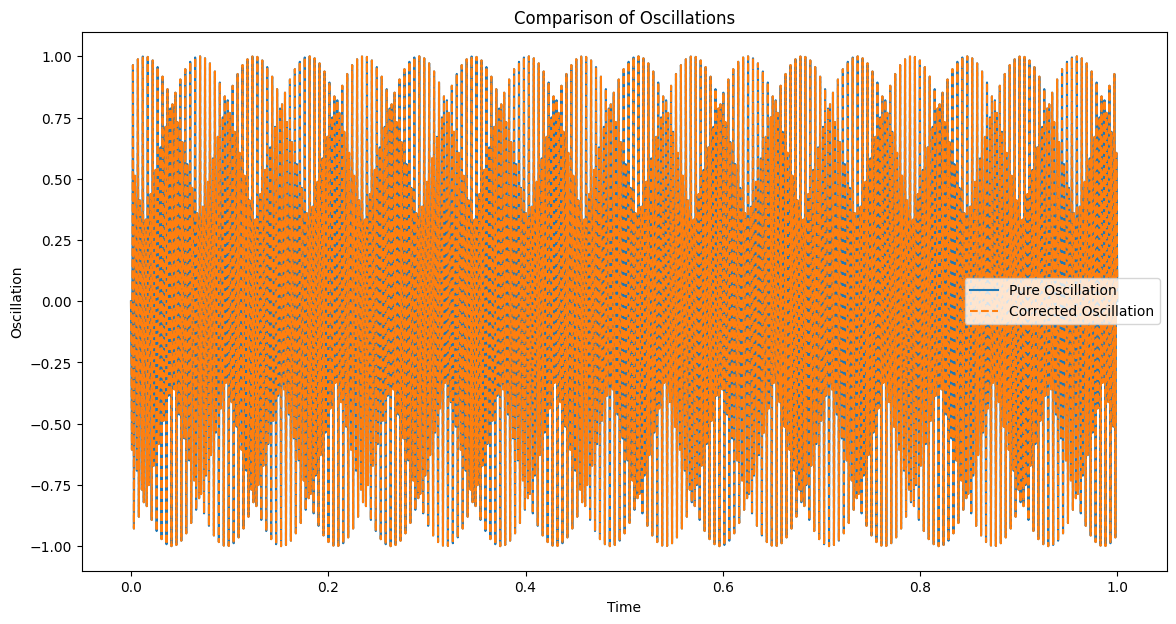

In [9]:
import ntplib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from time import ctime

# Function to get time from an NTP server
def get_ntp_time():
    client = ntplib.NTPClient()
    response = client.request('pool.ntp.org')
    return response.tx_time

# Simulate atomic oscillation without added noise for the training data
def simulate_atomic_oscillation(frequency):
    t = np.linspace(0, 1, 1000)
    pure_oscillation = np.sin(2 * np.pi * frequency * t)
    return t, pure_oscillation

# Generate synthetic dataset for training
def generate_synthetic_data(frequency, num_samples=1000):
    X = []
    y = []
    for _ in range(num_samples):
        t, pure_oscillation = simulate_atomic_oscillation(frequency)
        X.append(pure_oscillation)
        y.append(pure_oscillation)
    return np.array(X), np.array(y)

# Build and train the ANN model
def train_ann_model(X_train, y_train):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),  # Dropout layer to prevent overfitting
        Dense(128, activation='relu'),
        Dropout(0.2),  # Another dropout layer
        Dense(128, activation='relu'),
        Dense(X_train.shape[1])
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    # Early stopping to halt training when improvement stops
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])
    return model

# Correct the oscillation using the trained ANN model
@tf.function
def correct_oscillation(model, noisy_oscillation):
    corrected_oscillation = model(noisy_oscillation[np.newaxis, :])
    return corrected_oscillation[0]

# Integrate the ANN into the atomic clock function
def atomic_clock(model):
    ntp_time = get_ntp_time()
    seconds_since_epoch = int(ntp_time)
    nanoseconds = int((ntp_time - seconds_since_epoch) * 1e9)
    
    frequency = 9_192_631_770
    _, pure_oscillation = simulate_atomic_oscillation(frequency)
    corrected_oscillation = correct_oscillation(model, pure_oscillation)

    print(f"Seconds since epoch: {seconds_since_epoch}")
    print(f"Nanoseconds: {nanoseconds}")
    print(f"Corrected atomic oscillation (first 10 values): {corrected_oscillation[:10]}")

    # Generate some test data
    t, pure_oscillation = simulate_atomic_oscillation(frequency)

    # Correct the pure oscillation using the model
    corrected_oscillation = correct_oscillation(model, pure_oscillation)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(t, pure_oscillation, label='Pure Oscillation')
    plt.plot(t, corrected_oscillation, label='Corrected Oscillation', linestyle='dashed')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Oscillation')
    plt.title('Comparison of Oscillations')
    plt.show()

# Generate synthetic data and train the model
frequency = 9_192_631_770
X_train, y_train = generate_synthetic_data(frequency)
ann_model = train_ann_model(X_train, y_train)

# Call the atomic_clock function with the trained model
atomic_clock(ann_model)